# Lab 3d: The XOR Problem
In this lab, we'll look at the performance of [the Perceptron](https://en.wikipedia.org/wiki/Perceptron) and [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) on a dataset that is _not linearly seperable_, namely [the XOR dataset](https://en.wikipedia.org/wiki/Exclusive_or).

__Backstory__: In 1969, AI researchers [Marvin Minsky](https://en.wikipedia.org/wiki/Marvin_Minsky) and [Seymour Papert](https://en.wikipedia.org/wiki/Seymour_Papert) published a book called [Perceptrons](https://en.wikipedia.org/wiki/Perceptrons_(book)), in which they argued that [the perceptron built by Rosenblatt](https://en.wikipedia.org/wiki/Perceptron) was incapable of learning certain functions, one of those being [the XOR function](https://en.wikipedia.org/wiki/Exclusive_or). Soon after [Perceptrons](https://en.wikipedia.org/wiki/Perceptrons_(book)) was published, the first [AI winter](https://en.wikipedia.org/wiki/AI_winter) began.

### Tasks
Before we start, divide into teams and familiarize yourself with the lab. Then, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!

* __Task 1: Setup, Data, Constants (10 min)__: Let's take 10 minutes to review the dataset we'll explore today and set up some values we'll use in the other tasks. We'll load the data and do some initial _data munging_ (also called [data wrangling](https://en.wikipedia.org/wiki/Data_wrangling)) to get the dataset in a form that we'll use in our analysis.
* __Task 2: Build and Train Perceptron Classification Model (10 min)__: In this task, we'll build a model of our classification problem and train the model using an online learning method.
* __Task 3:  Build and Train Logistic Regression Classification Model (20 min)?__: In this task, we'll use the updated `model::MyPerceptronClassificationModel` instance (that has learned its parameters from the `training` data in _Task 2_) and test how well we classify data that we have never seen, i.e., how well we classify the `test` dataset. We'll then compute [the confusion matrix](https://github.com/varnerlab/CHEME-5820-Labs-Spring-2025/blob/main/labs/week-3/L3b/figs/Fig-BinaryConfusionMatrix.pdf) which we can use to test how well the classifier is working.

## Task 1: Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [3]:
include("Include.jl");

Next, let's set some constants. See the comment next to the constant for a description of what it is, permissible values, etc.

In [5]:
number_label_one = 1000; # number of points in cloud 1 (must be ≥ 2)
number_label_two = 1000; # number of points in cloud 2 (must be ≥ 2)
total_number_of_points = (number_label_one + number_label_two);
number_of_features = 3; # features: (x,y,l), where l is a label; see below.
c̄₁ = (0.0, 0.0); # center for cluster 1: fixed

Finally, let's set up the color dictionary to visualize the clustering results. The keys of the `my_color_dictionary::Dict{Int64, RGB}` dictionary class labels, while the values are the colors mapped to that label.

In [7]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e";
my_color_dictionary[-1] = colorant"#00b4d8";

### Data
In this lab, we'll use [the Perceptron (Rosenblatt, 1957)](https://en.wikipedia.org/wiki/Perceptron) and [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) to classify an [the XOR dataset](https://en.wikipedia.org/wiki/Exclusive_or) that we construct. First, we'll generate a master dataset and split it into `training` and `test` subsets.
* __Training data__: Training datasets are collections of labeled data used to teach machine learning models, allowing these tools to learn patterns and relationships within the data. In our case, we'll use the training data to estimate the classifier parameters $\beta$.
* __Test data__: Test datasets, on the other hand, are separate sets of labeled data used to evaluate the performance of trained models on unseen examples, providing an unbiased assessment of the _model's generalization capabilities_.

Let's start with the master dataset `D::Array{Float64,2}`. This dataset will have two continuous features $\mathbf{x}\in\mathbb{R}^{2}$ and a categorical label $y\in\{-1,1\}$.

In [9]:
D = let
    
    # initialize -
    D = Array{Float64,2}(undef, total_number_of_points, number_of_features);
    s₁ = generatedatacloud(c̄₁, number_of_points = number_label_one, label=0); # generate label 1 data
    s₂ = generatedatacloud(c̄₁, number_of_points = number_label_two, label=0); # generate label 2 data

    # mix s₁, s₂ together (randomly)
    tmp = vcat(s₁,s₂)
    random_perm_index_vector = randperm(total_number_of_points);
    for i ∈ eachindex(random_perm_index_vector)
        k = random_perm_index_vector[i]; # get the from col -
        for j ∈ 1:number_of_features
            D[i,j] = tmp[k,j];
        end
    end
    
    # compute the label by taking the XOR function
    for i ∈ 1:total_number_of_points
        flag = xor(D[i,1]≥0,D[i,2]≥0);
        if (flag == true)
            D[i,3] = 1
        else
            D[i,3] = -1
        end
    end
    D
end

2000×3 Matrix{Float64}:
 -0.116143    0.516888    1.0
  0.183625   -0.257756    1.0
  0.150497    0.221295   -1.0
  0.123835    0.618189   -1.0
  0.383041    0.913964   -1.0
 -0.0316     -0.0280651  -1.0
  0.0400444  -0.354098    1.0
  0.301513   -0.316965    1.0
 -0.368341   -0.589909   -1.0
  0.0434472   0.156321   -1.0
 -0.102531   -0.140022   -1.0
  0.668949   -0.266441    1.0
 -0.0856981  -0.292411   -1.0
  ⋮                      
  0.0974525   0.124676   -1.0
 -0.251492    0.214819    1.0
 -0.0393437  -0.456694   -1.0
  0.523968    0.590108   -1.0
  0.0480255  -0.2041      1.0
  0.216353   -0.0257094   1.0
  0.668886    0.368361   -1.0
 -0.38749    -0.47682    -1.0
 -0.447152   -0.27762    -1.0
 -0.0682886  -0.700257   -1.0
 -0.278704    0.51812     1.0
 -0.272318    0.737496    1.0

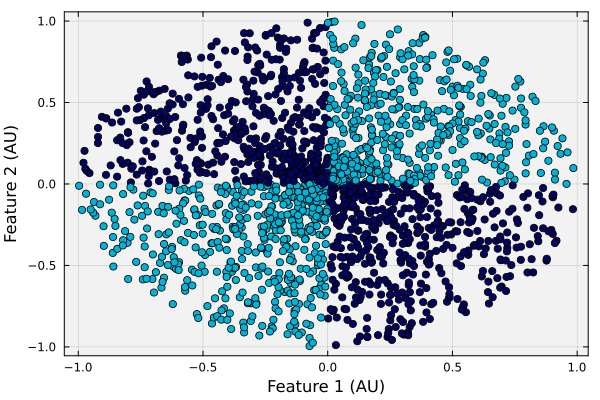

In [10]:
let

    dataset = D; # what dataset am I looking at?
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    for i ∈ 1:total_number_of_points
        label = dataset[i,3]; # label
        c = my_color_dictionary[label]
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end
    
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

In [11]:
training, test = let

    number_of_training_examples = 1200; # we make this number of
    number_of_examples = total_number_of_points;
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    should_stop_loop = false;
    while (should_stop_loop == false)
        i = rand(1:number_of_examples);
        push!(training_index_set,i);

        if (length(training_index_set) == number_of_training_examples)
            should_stop_loop = true;
        end
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    training = D[training_index_set |> collect,:];
    test = D[test_index_set |> collect,:];

    # return
    training, test
end;

In [12]:
training

1200×3 Matrix{Float64}:
  0.622273   -0.533912     1.0
  0.463343    0.299829    -1.0
  0.0257297  -0.00563895   1.0
 -0.0430699   0.830841     1.0
  0.622762   -0.0813686    1.0
 -0.026568   -0.102815    -1.0
 -0.147479    0.881551     1.0
  0.103043    0.178264    -1.0
 -0.0714305  -0.549268    -1.0
 -0.122941    0.468558     1.0
 -0.0569282  -0.257664    -1.0
 -0.329124    0.0162582    1.0
  0.0845234   0.521976    -1.0
  ⋮                       
  0.136162   -0.0452109    1.0
 -0.404279   -0.339784    -1.0
  0.517205   -0.487312     1.0
 -0.019668   -0.315207    -1.0
 -0.244451    0.794128     1.0
 -0.374703    0.30358      1.0
  0.371418   -0.377678     1.0
 -0.128818   -0.0345741   -1.0
 -0.463645    0.601914     1.0
  0.061951    0.336265    -1.0
 -0.573743   -0.101093    -1.0
 -0.76184    -0.1317      -1.0

Visualize

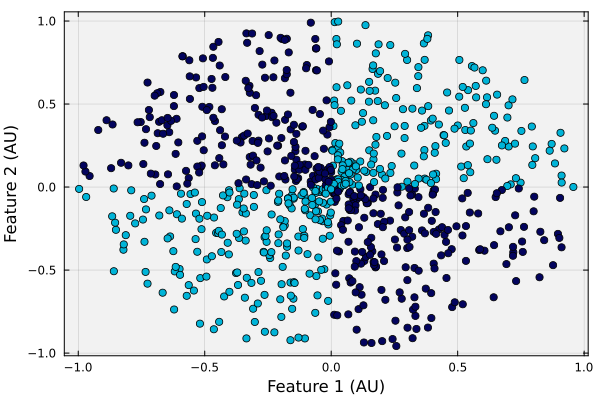

In [14]:
let

    dataset = test; # what dataset am I looking at?
    number_of_points = size(dataset,1); # number of rows
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    for i ∈ 1:number_of_points
        label = dataset[i,3]; # label
        c = my_color_dictionary[label]
        scatter!([dataset[i, 1]], [dataset[i, 2]], label="", mec=:navy, c=c)
    end
    
    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

## Task 2: Build a Perceptron Classification Model and Learn the Parameters
In this task, we'll build a model of our classification problem and train the model using an online learning method. 
* __Training__: Our Perceptron implementation [based on pseudo-code](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-3/L3a/docs/Notes.pdf) stores problem information in [a `MyPerceptronClassificationModel` instance, which holds the (initial) parameters and other data](src/Types.jl) required by the problem. We initialize the parameters using a vector of `1`'s.
* Next, we then _learn_ the model parameters [using the `learn(...)` method](src/Compute.jl), which takes the training features array `X,` the training labels vector `y`, and the problem instance and returns an updated problem instance holding the updated parameters. 

In [16]:
perceptron_model = let
    
    # setup
    D = training; # what dataset are we going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features, what??
    y = D[:,end]; # output: this is the target data (label)
    
    # build an initial model
    model = build(MyPerceptronClassificationModel, (
        parameters = ones(number_of_features),
        mistakes = 0 # willing to live with m mistakes
    ));

    # train the model -
    trainedmodel = learn(X,y,model, maxiter = 1000, verbose = true);

    # return -
    trainedmodel;
end;

Stopped after number of iterations: 1000. We have number of errors: 580


__Inference__: Now that we have parameters estimated from the `training` data, we can use those parameters on the `test` dataset to see how well the model can differentiate between classes on data it has never seen. 
* We run the classification operation on the (unseen) test data [using the `classify(...)` method](src/Compute.jl). This method takes a feature array `X` and the (trained) model instance. It returns the estimated labels. 
* We store the actual (correct) label in the `y_perceptron::Array{Int64,1}` vector, while the model predicted label is stored in the `ŷ_perceptron::Array{Int64,1}` array.

In [18]:
ŷ_perceptron,y_perceptron = let

    D = test; # what dataset are going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the *actual* target data (label)

    # compute the estimated labels -
    ŷ = classify(X,perceptron_model)

    # return -
    ŷ,y
end;

### Confusion Matrix
The confusion matrix is a $2\times{2}$ matrix that contains four entries: true positive (TP), false positive (FP), true negative (TN), and false negative (FN). [Click me for a confusion matrix schematic!](https://github.com/varnerlab/CHEME-5820-Labs-Spring-2025/blob/main/labs/week-3/L3b/figs/Fig-BinaryConfusionMatrix.pdf) The four cases are:
* The __true positive (TP)__ case $(\text{actual}, \text{model}) = (+,+)$ in the confusion matrix is the number of positive examples that were correctly classified as positive.
* The __false negative (FN)__ case $(\text{actual}, \text{model}) = (+,-)$ is the number of actual positive examples the model incorrectly classified as negative.
* The __false positive (FP)__ case $(\text{actual}, \text{model}) = (-,+)$ is the number of actual negative examples that were incorrectly classified as positive by the model.
* The __true negative (TN)__ case $(\text{actual}, \text{model}) = (-,-)$ is the number of actual negative examples that were correctly classified as negative by the model.

Let's compute these four values [using the `confusion(...)` method](src/Compute.jl) and store them in the `CM_perceptron::Array{Int64,2}` variable:

In [20]:
CM_perceptron = confusion(y_perceptron, ŷ_perceptron)

2×2 Matrix{Int64}:
 0  400
 0  400

Let's compute the overall error rate for the perceptron using [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The [`confusion(...)` method](src/Compute.jl) takes the actual labels and the computed labels and returns the confusion matrix.

In [22]:
number_of_test_points = length(y_perceptron);
correct_prediction_perceptron = CM_perceptron[1,1] + CM_perceptron[2,2];
(correct_prediction_perceptron/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")

Fraction correct: 0.5 Fraction incorrect 0.5


## Task 3: Build and Train Logistic Regression Classification Model
[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) is a method for binary classification problems, where the dependent variable (label) is a binary categorical variable (e.g., $\pm{1}$, etc.), and the independent variables (features) are continuous or categorical variables. Unlike the Perceptron model, which outputs the class label directly, logistic regression models the _probability_ that a given input belongs to a particular class based on the input features.

### Implementation
We implemented [the `MyLogisticRegressionClassificationModel` type](src/Types.jl), which contains data required to solve the logistic regression problem, i.e., parameters, the learning rate, a stopping tolerance parameter $\epsilon$, and a loss (objective) function that we want to minimize. 
* __Technical note__: In this implementation, we approximated the gradient calculation using [a forward finite difference](https://en.wikipedia.org/wiki/Finite_difference). In general, this is not a great idea. This is one of my super pet peeves of gradient descent; computing the gradient is usually a hassle, and we do a bunch of function evaluations to get a good approximation of the gradient. However, finite difference is easy to implement.
* In the code block below, we [build a `model::MyLogisticRegressionClassificationModel` instance using a `build(...)` method](src/Factory.jl). The model instance initially has a random guess for the classifier parameters. We use gradient descent to refine that guess [using the `learn(...)` method](src/Compute.jl), which returns an updated model instance (with the best parameters that we found so far). We return the updated model instance and save it in the `model_logistic::MyLogisticRegressionClassificationModel` variable.

In [24]:
model_logistic = let

    # data -
    D = training; # What dataset are we going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the target data (label)

    # model
    model = build(MyLogisticRegressionClassificationModel, (
        parameters = 0.01*ones(number_of_features), # initial value for the parameters: these will be updated
        learning_rate = 0.005, # you pick this
        ϵ = 1e-4, # you pick this (this is also the step size for the fd approx to the gradient)
        loss_function = (x,y,θ) -> log10(1+exp(-y*(dot(x,θ)))) # what??!? Wow, that is nice. Yes, we can pass functions as args!
    ));

    # train -
    model = learn(X,y,model, maxiter = 10000, verbose = true); # this is learning the model parameters

    # return -
    model;
end;

Stopped after number of iterations: 94. We have error: 9.245797107869738e-5


Let's use the updated `model_logistic::MyLogisticRegressionClassificationModel` instance (that has learned some parameters from the `training` data) and test how well we classify data that we have never seen, i.e., how well we classify the `test` dataset.

__Inference__: We run the classification operation on the (unseen) test data [using the `classify(...)` method](src/Compute.jl). This method takes a feature array `X` and the (trained) model instance. It returns the probability of a label in the `P::Array{Float64,2}` array (which is different than the Perceptron). Each row of `P` corresponds to a test instance, in which each column corresponds to a label, in the case `1` and `-1`.
* We store the actual (correct) label in the `y_logistic::Array{Int64,1}` vector. We compute the predicted label for each test instance by finding the highest probability column. We store the predicted labels in the `ŷ_logistic::Array{Int64,1}` vector.

In [41]:
ŷ_logistic,y_logistic, P = let

    D = test; # What dataset are you going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the *actual* target data (label)

    # compute the estimated labels -
    P = classify(X,model_logistic) # logistic regression returns a x x 2 array holding the probability

    # convert the probability to a choice ... for each row (test instance), compute the col with the highest probability
    ŷ = zeros(number_of_examples);
    for i ∈ 1:number_of_examples
        a = argmax(P[i,:]); # col index with largest value
        ŷ[i] = 1; # default
        if (a == 2)
            ŷ[i] = -1;
        end
    end
    
    # return -
    ŷ, y, P
end;

In [43]:
P

800×2 Matrix{Float64}:
 0.511812  0.488188
 0.492805  0.507195
 0.492764  0.507236
 0.492267  0.507733
 0.48554   0.51446
 0.514563  0.485437
 0.489976  0.510024
 0.489753  0.510247
 0.493914  0.506086
 0.499642  0.500358
 0.476628  0.523372
 0.496055  0.503945
 0.475514  0.524486
 ⋮         
 0.520442  0.479558
 0.476238  0.523762
 0.508646  0.491354
 0.492419  0.507581
 0.494734  0.505266
 0.499608  0.500392
 0.496828  0.503172
 0.4971    0.5029
 0.477678  0.522322
 0.477338  0.522662
 0.496121  0.503879
 0.512041  0.487959

__Performance__: Once we have has converged, we can evaluate the binary classifier's performance using various metrics. The central idea is to compare the predicted labels $\hat{y}_{i}$ to the actual labels $y_{i}$ in the `test` dataset. 
Various metrics can be used to evaluate the performance of a binary classifier, but they all start with computing [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
* Let's compute confusion matrix [using the `confusion(...)` method](src/Compute.jl) and store it in the `CM_logistic::Array{Int64,2}` variable. The [`confusion(...)` method](src/Compute.jl) takes the actual labels and the computed labels and returns the confusion matrix.

In [46]:
CM_logistic = confusion(y_logistic, ŷ_logistic)

2×2 Matrix{Int64}:
  90  310
 122  278

Let's compute the overall error rate for the logistic regression using [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

In [49]:
number_of_test_points = length(y_perceptron);
correct_prediction_logistic = CM_logistic[1,1] + CM_logistic[2,2];
(correct_prediction_logistic/number_of_test_points) |> f-> println("Fraction correct: $(f) Fraction incorrect $(1-f)")

Fraction correct: 0.46 Fraction incorrect 0.54
